In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Data

In [2]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 64
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

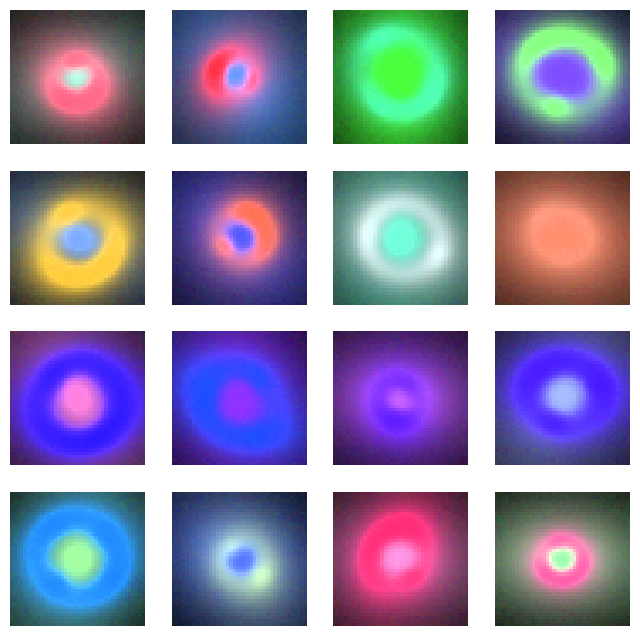

In [3]:
# Visualize source data
visualize_data(source_data)

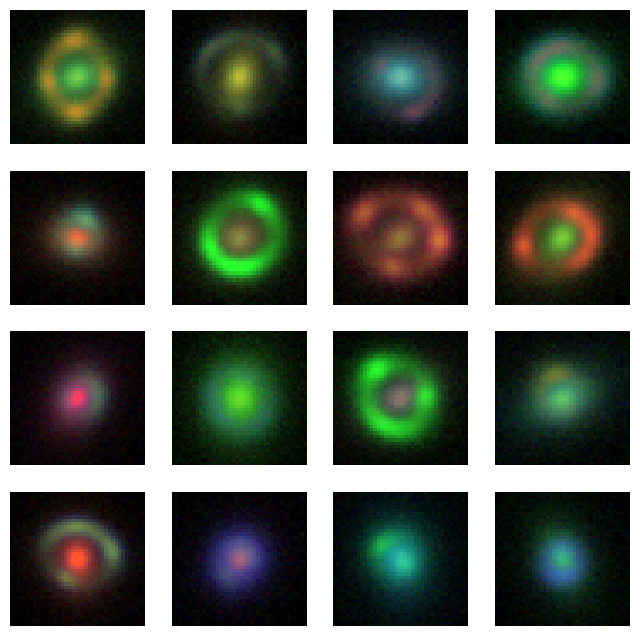

In [4]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [5]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return 0

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)
    return beta_val

# Initialize hyperparameters
learning_rate = 1e-5
n_epoch = 250
extra_epoch = n_epoch
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.0

In [6]:
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None #"models/mve_noDA_v1_aug7_0100" # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/mve_noDA_v2_aug7_1850"

## Train

Beginning Training...
Generating Isomap...


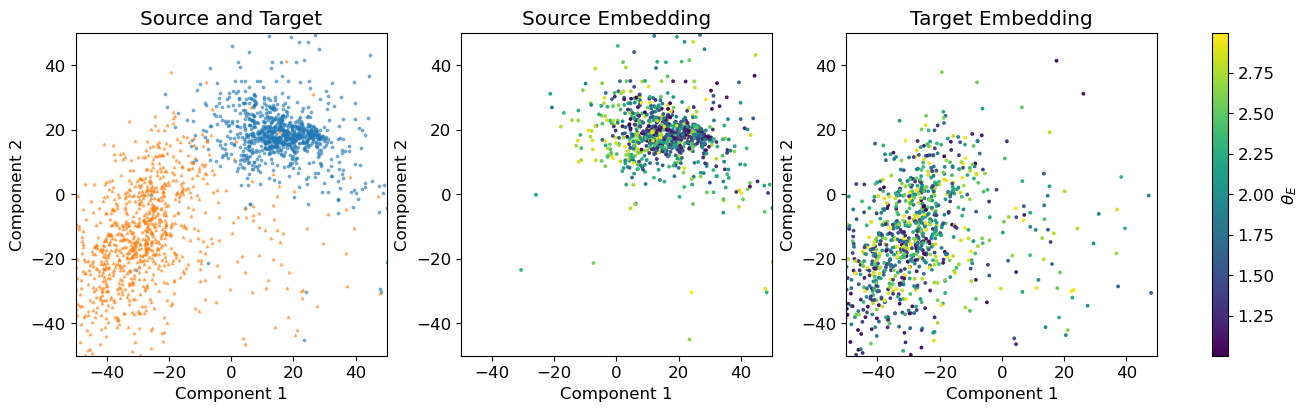


Epoch 0: 10.69s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4823
	Train Regression Loss: : 3.2100
	Train Mve Loss: : 1.4617
	Train R2 Score: : -8.8634
 Validation Statistics:
	Val Source Regression Loss: : 2.5287
	Val Target Regression Loss: : 2.5122
	Val Source R2 Score: : -6.7477
	Val Target R2 Score: : -6.8279
	Val Source Mve Loss: : 1.0963
	Val Target Mve Loss: : 1.0880
Saving Model MVE... Done.

Epoch 1: 11.23s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4534
	Train Regression Loss: : 1.8870
	Train Mve Loss: : 0.7783
	Train R2 Score: : -4.7996
 Validation Statistics:
	Val Source Regression Loss: : 1.4130
	Val Target Regression Loss: : 1.3867
	Val Source R2 Score: : -3.3894
	Val Target R2 Score: : -3.3451
	Val Source Mve Loss: : 0.5415
	Val Target Mve Loss: : 0.5255
Saving Model MVE... Done.

Epoch 2: 11.01s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4336
	Train Regression Loss: : 1.0224
	Tr

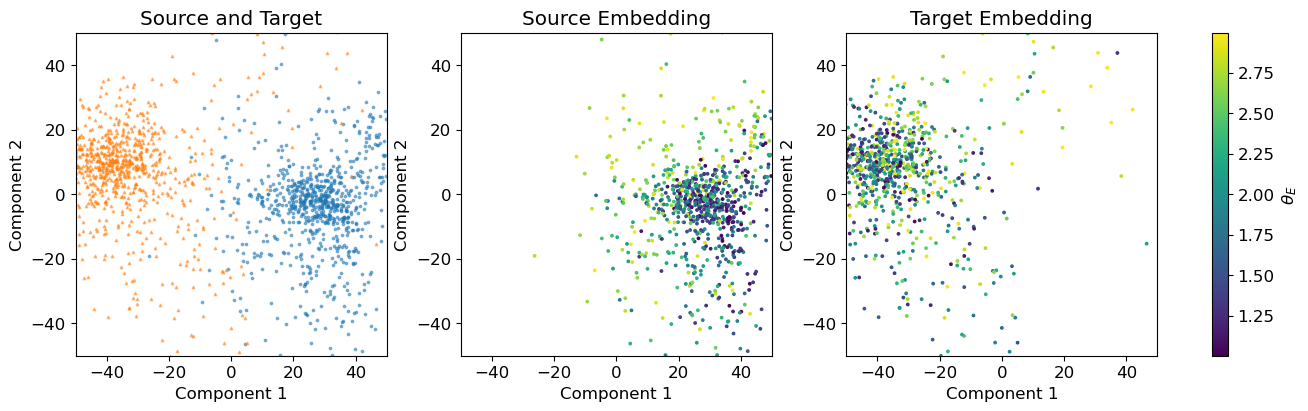


Epoch 20: 13.02s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3729
	Train Regression Loss: : 0.0350
	Train Mve Loss: : -0.1085
	Train R2 Score: : 0.8925
 Validation Statistics:
	Val Source Regression Loss: : 0.0355
	Val Target Regression Loss: : 0.0586
	Val Source R2 Score: : 0.8888
	Val Target R2 Score: : 0.8189
	Val Source Mve Loss: : -0.0995
	Val Target Mve Loss: : -0.0437

Epoch 21: 11.52s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3698
	Train Regression Loss: : 0.0339
	Train Mve Loss: : -0.0915
	Train R2 Score: : 0.8960
 Validation Statistics:
	Val Source Regression Loss: : 0.0342
	Val Target Regression Loss: : 0.0586
	Val Source R2 Score: : 0.8962
	Val Target R2 Score: : 0.8200
	Val Source Mve Loss: : -0.1233
	Val Target Mve Loss: : -0.0736

Epoch 22: 10.52s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3693
	Train Regression Loss: : 0.0327
	Train Mve Loss: : -0.0909
	Train R2 Score: : 0.8997

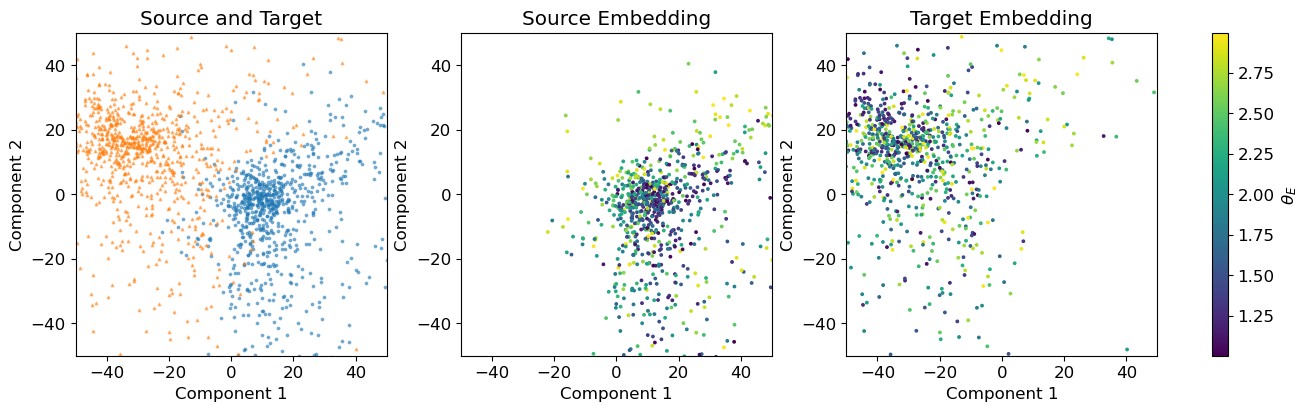


Epoch 40: 10.72s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3715
	Train Regression Loss: : 0.0216
	Train Mve Loss: : -0.0884
	Train R2 Score: : 0.9336
 Validation Statistics:
	Val Source Regression Loss: : 0.0228
	Val Target Regression Loss: : 0.0681
	Val Source R2 Score: : 0.9306
	Val Target R2 Score: : 0.7791
	Val Source Mve Loss: : -0.0728
	Val Target Mve Loss: : 0.1283

Epoch 41: 10.64s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3723
	Train Regression Loss: : 0.0212
	Train Mve Loss: : -0.0964
	Train R2 Score: : 0.9352
 Validation Statistics:
	Val Source Regression Loss: : 0.0222
	Val Target Regression Loss: : 0.0662
	Val Source R2 Score: : 0.9325
	Val Target R2 Score: : 0.7952
	Val Source Mve Loss: : -0.0700
	Val Target Mve Loss: : 0.1469

Epoch 42: 10.42s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3717
	Train Regression Loss: : 0.0208
	Train Mve Loss: : -0.1370
	Train R2 Score: : 0.9361
 

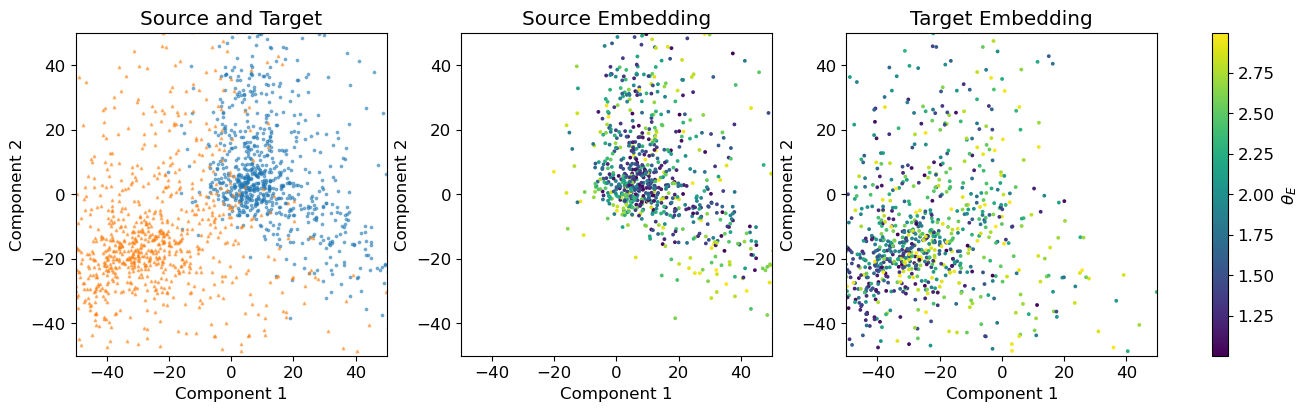


Epoch 60: 10.79s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3700
	Train Regression Loss: : 0.0172
	Train Mve Loss: : -0.1182
	Train R2 Score: : 0.9475
 Validation Statistics:
	Val Source Regression Loss: : 0.0181
	Val Target Regression Loss: : 0.0717
	Val Source R2 Score: : 0.9451
	Val Target R2 Score: : 0.7798
	Val Source Mve Loss: : -0.1596
	Val Target Mve Loss: : 0.0892

Epoch 61: 10.69s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3710
	Train Regression Loss: : 0.0172
	Train Mve Loss: : -0.1916
	Train R2 Score: : 0.9472
 Validation Statistics:
	Val Source Regression Loss: : 0.0186
	Val Target Regression Loss: : 0.0707
	Val Source R2 Score: : 0.9434
	Val Target R2 Score: : 0.7801
	Val Source Mve Loss: : -0.1579
	Val Target Mve Loss: : 0.1727

Epoch 62: 11.30s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3731
	Train Regression Loss: : 0.0172
	Train Mve Loss: : -0.1403
	Train R2 Score: : 0.9474
 

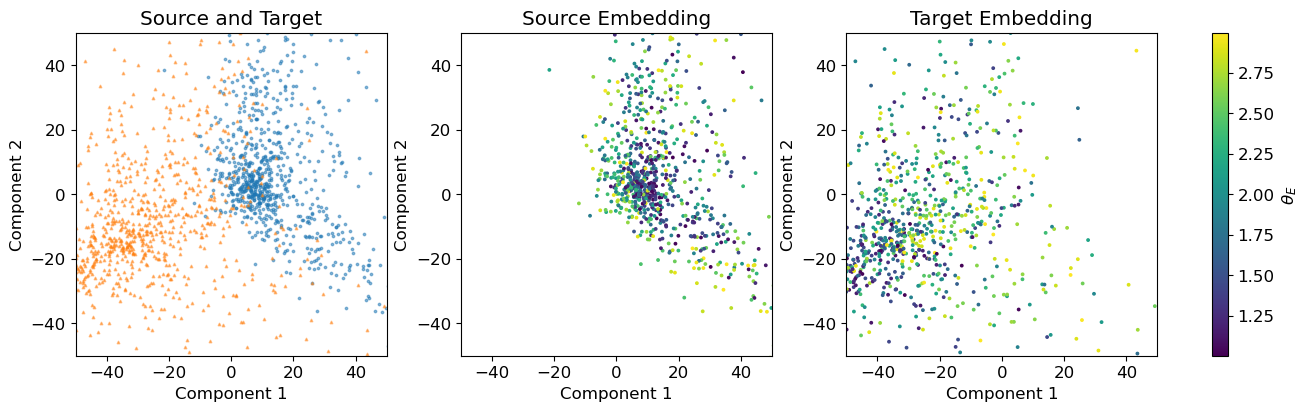


Epoch 80: 10.40s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3784
	Train Regression Loss: : 0.0154
	Train Mve Loss: : -0.1479
	Train R2 Score: : 0.9528
 Validation Statistics:
	Val Source Regression Loss: : 0.0165
	Val Target Regression Loss: : 0.0773
	Val Source R2 Score: : 0.9501
	Val Target R2 Score: : 0.7601
	Val Source Mve Loss: : -0.0917
	Val Target Mve Loss: : 2.6798

Epoch 81: 10.73s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3779
	Train Regression Loss: : 0.0154
	Train Mve Loss: : -0.1839
	Train R2 Score: : 0.9527
 Validation Statistics:
	Val Source Regression Loss: : 0.0168
	Val Target Regression Loss: : 0.0779
	Val Source R2 Score: : 0.9483
	Val Target R2 Score: : 0.7596
	Val Source Mve Loss: : -0.1207
	Val Target Mve Loss: : 2.5707

Epoch 82: 10.87s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3761
	Train Regression Loss: : 0.0155
	Train Mve Loss: : -0.1531
	Train R2 Score: : 0.9525
 

KeyboardInterrupt: 

In [9]:
print("Beginning Training...")


for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + extra_epoch):

        #Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1

        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [10]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [11]:
# Loads a model for plotting/viz

viz_mod_name = final_mod_name # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

In [12]:
stat_tab = pd.DataFrame(stats)
stat_tab

,train_DA_loss,train_regression_loss,train_mve_loss,train_r2_score,val_source_regression_loss,val_target_regression_loss,val_source_r2_score,val_target_r2_score,val_source_mve_loss,val_target_mve_loss,da_weight,beta,epoch_no
0,0.482323,3.209984,1.461657,-8.863407,2.528743,2.512163,-6.747748,-6.827863,1.096271,1.088024,0,1.000,89
1,0.453402,1.886992,0.778321,-4.799637,1.413024,1.386670,-3.389414,-3.345138,0.541524,0.525467,0,0.996,89
2,0.433625,1.022398,0.349970,-2.132105,0.754605,0.731918,-1.316231,-1.269050,0.216855,0.201756,0,0.992,89
3,0.420231,0.565999,0.123364,-0.733587,0.450252,0.435867,-0.364350,-0.355838,0.063787,0.053141,0,0.988,89
4,0.416523,0.377741,0.025909,-0.153014,0.341336,0.331893,-0.047856,-0.024190,0.004537,-0.002900,0,0.984,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.377094,0.015392,-0.192382,0.952858,0.016738,0.077845,0.949249,0.756629,-0.207531,1.025278,0,0.664,89
85,0.380862,0.015363,-0.160656,0.952891,0.016559,0.080202,0.949802,0.749011,-0.122350,3.623529,0,0.660,89
86,0.382453,0.015213,-0.140816,0.953359,0.016350,0.076713,0.950491,0.763809,-0.084979,3.925520,0,0.656,89
87,0.381229,0.015164,-0.142047,0.953571,0.015990,0.079403,0.951468,0.753794,-0.110802,4.125695,0,0.652,89


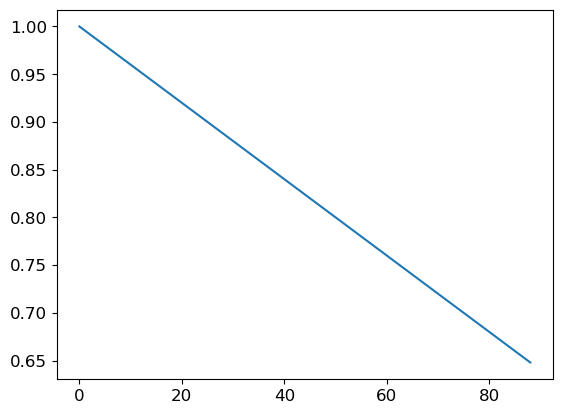

In [13]:
plt.plot(stat_tab['beta']) 

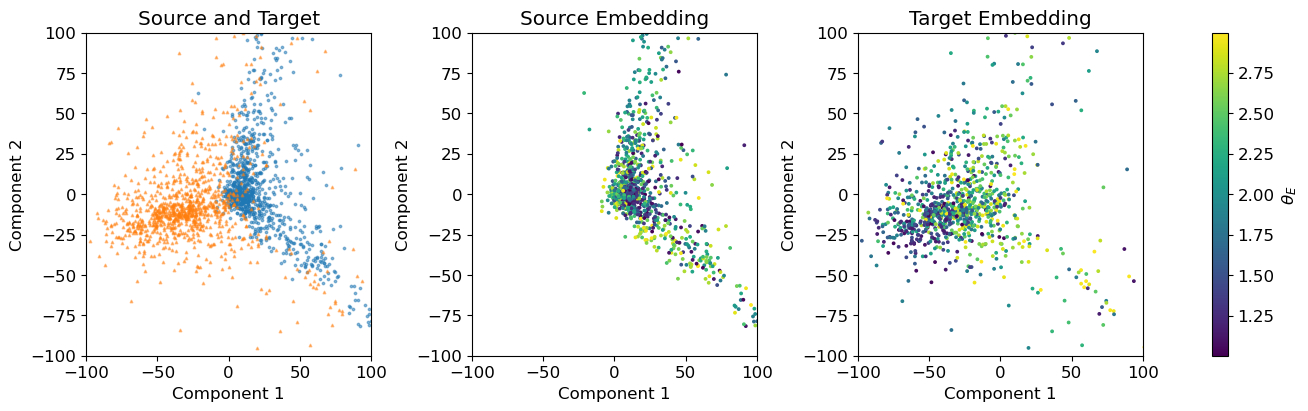

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [14]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 100)

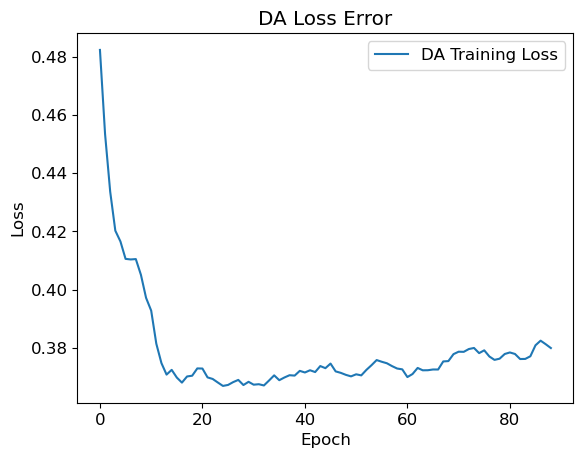

In [15]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

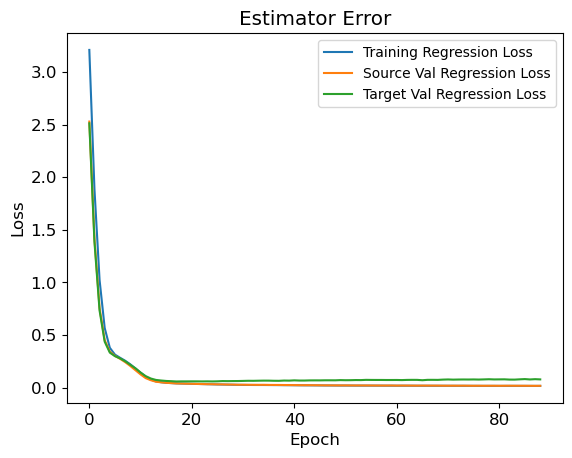

In [16]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

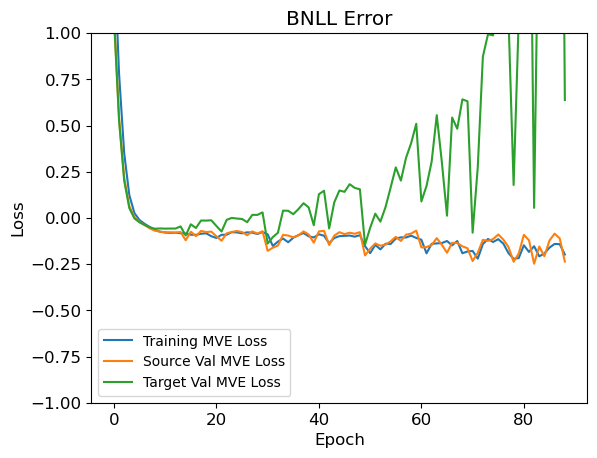

In [17]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

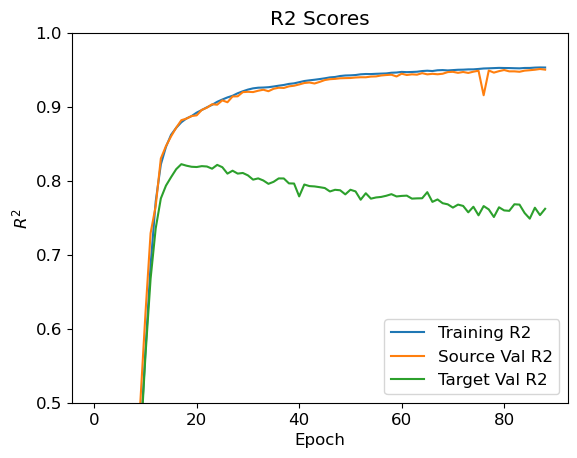

In [18]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [19]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9511


Text(0.5, 1.0, 'MMD | Source | R2: 0.951')

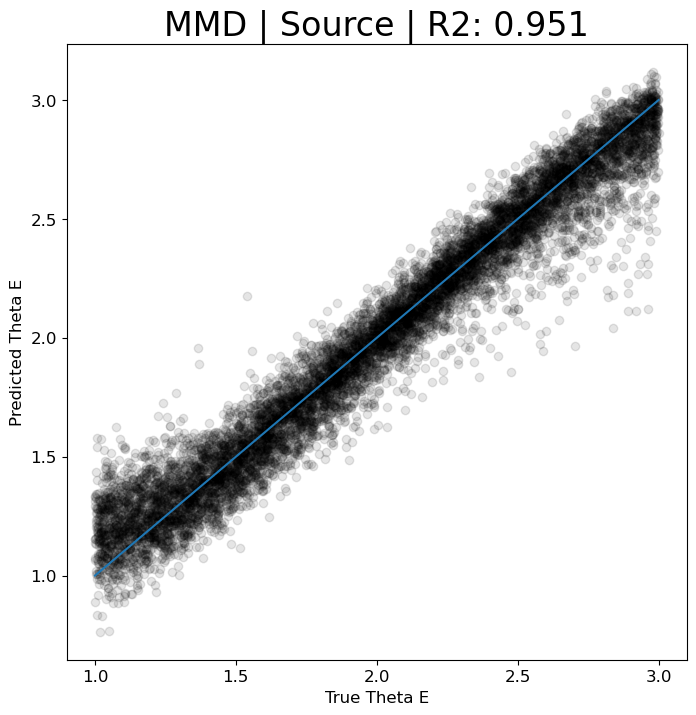

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.141')

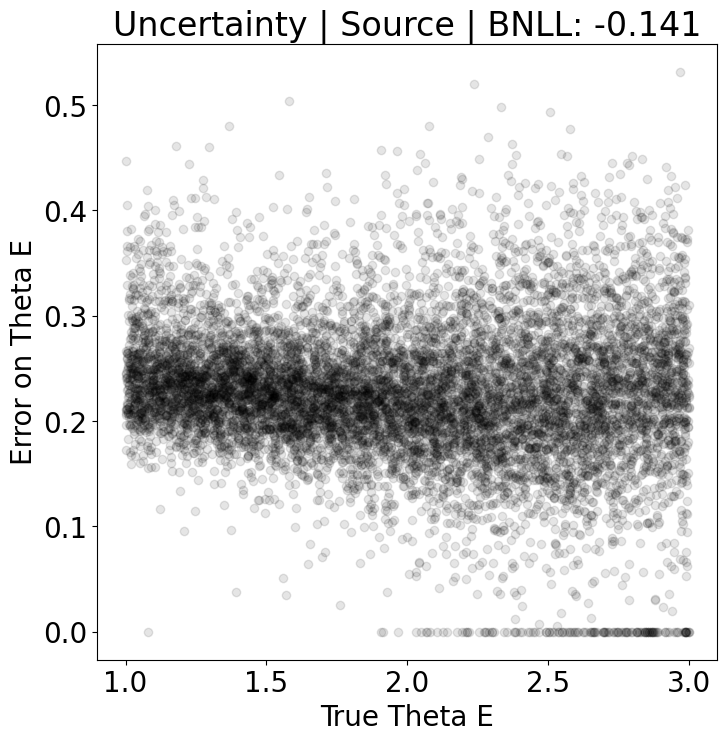

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [22]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.7461


Text(0.5, 1.0, 'MMD | Target | R2: 0.746')

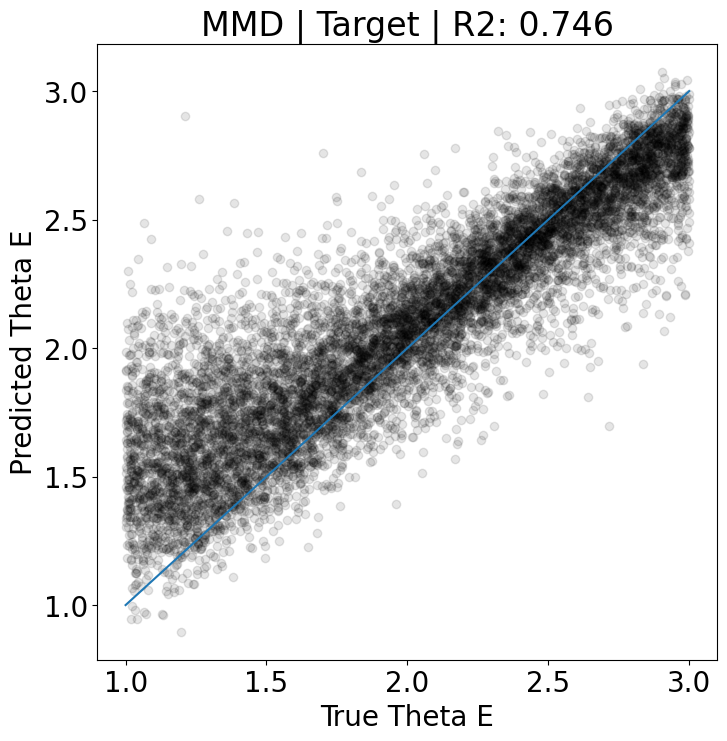

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.746')

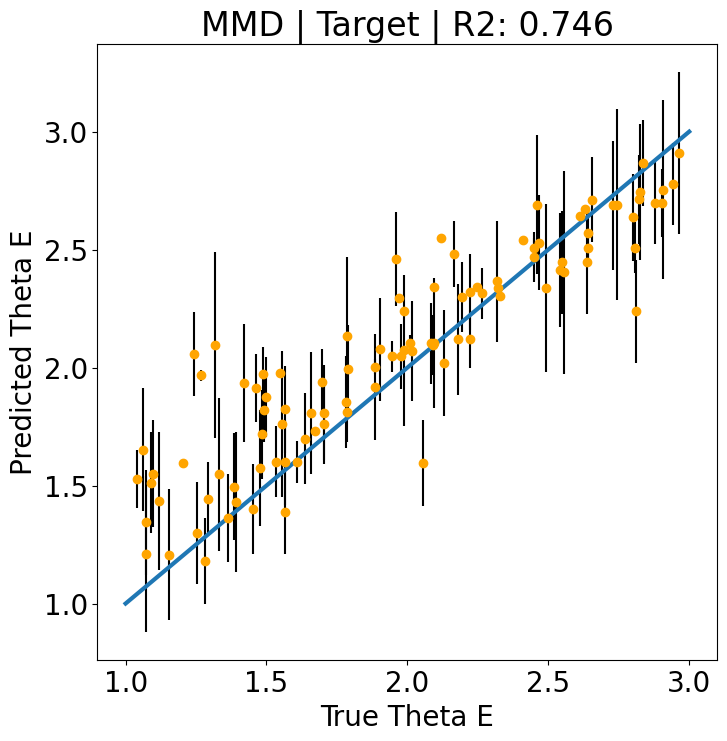

In [24]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: 41.146')

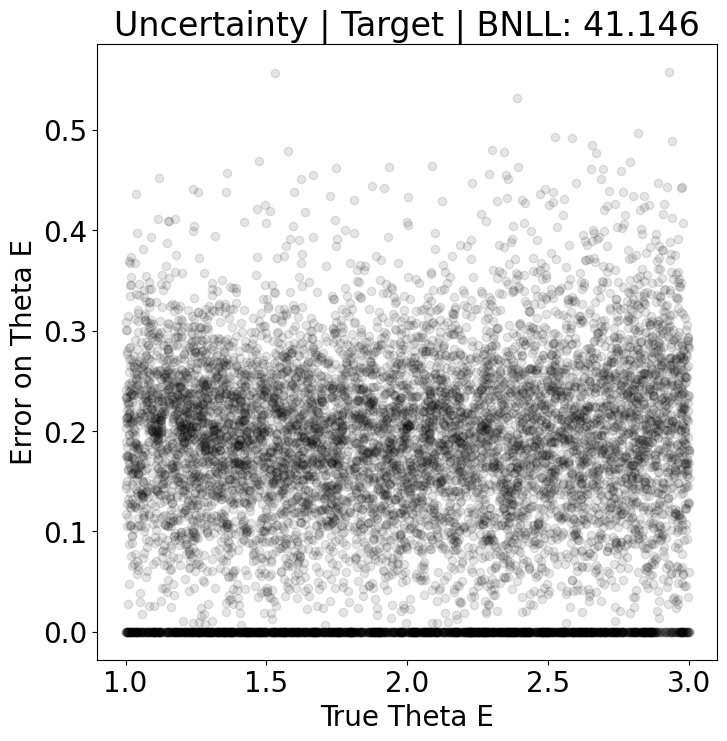

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [26]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

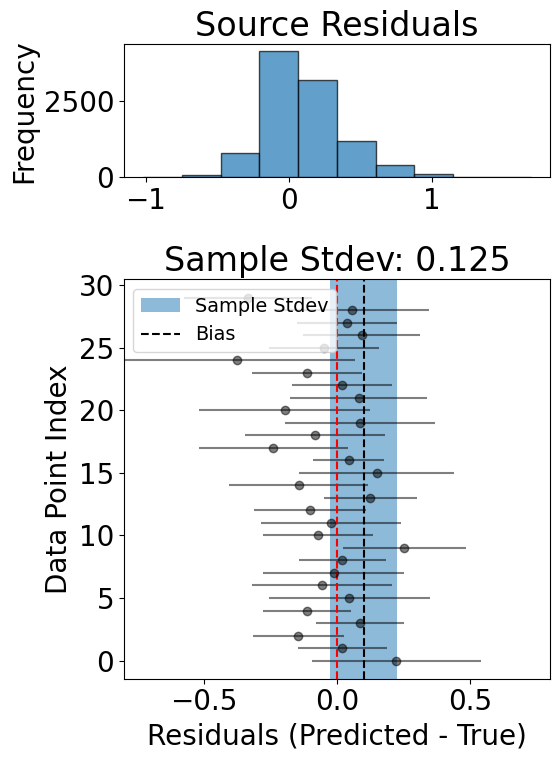

In [27]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

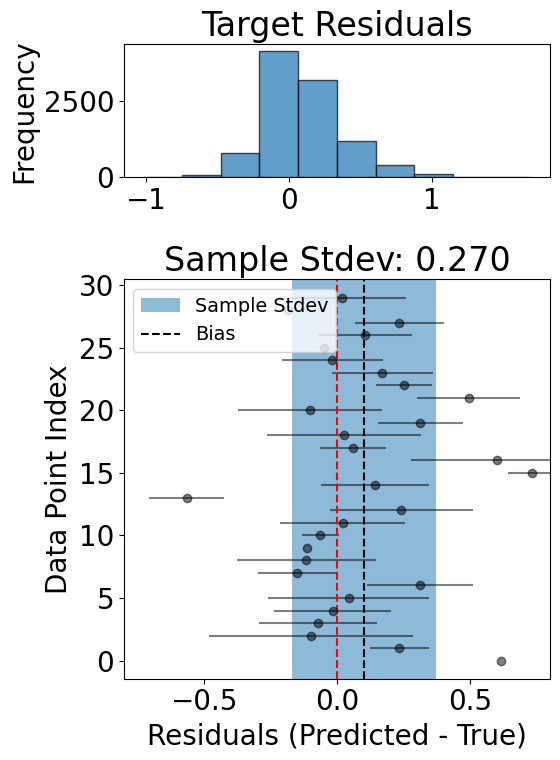

In [28]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()